In [10]:
#importing stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline


In [11]:
#Complete cell to create money metrics df for merging

#importing data from csz
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets_df

#renaming it to work on
money_metrics_df = tn_movie_budgets_df

#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

#cleaning
money_metrics_df = clean_a_money_column(money_metrics_df,'worldwide_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'domestic_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'production_budget')


##Unique ID for later merging madness

money_metrics_df['mmdf_uni_id'] = money_metrics_df.index



#adding profit margin and ROI columns
money_metrics_df['Profit Margin']= (money_metrics_df['worldwide_gross']-money_metrics_df['production_budget'])/money_metrics_df['worldwide_gross']
money_metrics_df['ROI'] = (money_metrics_df['worldwide_gross']/money_metrics_df['production_budget'])

#setting profit margin desc as order for the table
money_metrics_df=money_metrics_df.sort_values(['Profit Margin'], ascending=False)

#dropping the zeros gross films
#This may be be very generous to our ROI data later, but we have to assume a literal 0 return is 
#more likely bad data in than a literal 0 revenue. 
#these film makers have parents, that at least would provide some box office.

money_metrics_df = money_metrics_df[money_metrics_df['worldwide_gross'] != 0]

#creating year and month columns
#Vu's magic lambda, plus to numeric on the year 
money_metrics_df['Year'] = pd.to_numeric(money_metrics_df['release_date'].map(lambda x: x[-4:]))
money_metrics_df['Month'] = money_metrics_df['release_date'].map(lambda x: x[:3])

#I did this at some point and it breaks if I don't do it here
money_metrics_df.set_index('movie', inplace = True)
money_metrics_df.index.rename('Movie', inplace = True)

#vu's dupe check
movie_dupes = pd.Series(tn_movie_budgets_df['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]


#making a new df to do the rename in
title_dupes_df = money_metrics_df[money_metrics_df.index.isin(title_dupes)].copy()

#reset the index for easier editing
title_dupes_df.reset_index(inplace = True)

title_dupes_df.head(5)

#Making new columns, setting year to string for concat
title_dupes_df['Yearasastring'] = title_dupes_df['Year'].map(lambda x: str(x))
#Making the new title by combining the name of the movie and the year of release
title_dupes_df['New Title'] = title_dupes_df['Movie']+' '+title_dupes_df['Yearasastring'].copy()
#creating a new DF dropping all the columns we don't need 
title_dupes_df_merger = title_dupes_df[['mmdf_uni_id', 'New Title']]
#Don't actually know if we need this but, whatever.
money_metrics_df.reset_index(inplace = True)


#reintegrating new titles in a new df mergedf
mergedf = money_metrics_df.merge(title_dupes_df_merger, on = 'mmdf_uni_id', how= 'left')

#vu's slightly less magical de-duplicator

#new column for boolean
mergedf['is_title_NaN'] = mergedf['New Title'].isnull()

#for loop to rename 'Movie'
for movie_index in list(range(len(mergedf.index))):
    if  ~mergedf['is_title_NaN'][movie_index]:
        mergedf['Movie'][movie_index] = mergedf['New Title'][movie_index]

        
money_metrics_merge_ready = mergedf   


#### NOW OUTPUTS A DF CALLED money_metrics_merge_ready
#### TRY TO NOT MESS WITH THIS BLOCK, MAKE A COPY OF money_metrics_merge_ready
#### AND MESS WITH THAT        



<ipython-input-11-b504f3a2177c>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergedf['Movie'][movie_index] = mergedf['New Title'][movie_index]


In [39]:
months_and_years_df

,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN,alphaMonths
1,Mad Max,14,"Mar 21, 1980",200000,8750000,99750000,5613,0.997995,498.750000,1980,Mar,NaN,True,03 - March
2,Paranormal Activity,93,"Sep 25, 2009",450000,107918810,194183034,5492,0.997683,431.517853,2009,Sep,NaN,True,09 - September
3,The Gallows,80,"Jul 10, 2015",100000,22764410,41656474,5679,0.997599,416.564740,2015,Jul,NaN,True,07 - July
4,The Blair Witch Project,7,"Jul 14, 1999",600000,140539099,248300000,5406,0.997584,413.833333,1999,Jul,NaN,True,07 - July
5,Super Size Me,10,"May 7, 2004",65000,11529368,22233808,5709,0.997077,342.058585,2004,May,NaN,True,05 - May
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,Food Chains,36,"Nov 21, 2014",913000,0,176,5335,-5186.500000,0.000193,2014,Nov,NaN,True,11 - November
5411,The Grimm Brothers' Snow White,53,"Aug 24, 1997",26000000,5000,5000,2152,-5199.000000,0.000192,1997,Aug,NaN,True,08 - August
5412,Skin Trade,19,"May 8, 2015",9000000,1242,1242,3818,-7245.376812,0.000138,2015,May,NaN,True,05 - May
5413,Perrierâs Bounty,82,"May 21, 2010",6600000,828,828,4081,-7970.014493,0.000125,2010,May,NaN,True,05 - May


In [12]:
months_and_years_df = money_metrics_merge_ready

# Removing Deep Throat on principle. It's numbers were apparently pumped by mob involvement and
# apparently the lead talent was coerced into performing, which, ick.
# Also it's messing up my graphs.

months_and_years_df=months_and_years_df.drop([0])


In [13]:
months_and_years_df['alphaMonths']=months_and_years_df['Month']

In [14]:
#Making our months alphabetical, for later graphing purposes.

def alphamonth(month):
    if month == 'Jan':
        amonth = '01 - January'
    elif month == 'Feb':
        amonth = '02 - February'
    elif month == 'Mar':
        amonth = '03 - March'
    elif month == 'Apr':
        amonth = '04 - April'
    elif month == 'May':
        amonth = '05 - May'
    elif month == 'Jun':
        amonth = '06 - June'
    elif month == 'Jul':
        amonth = '07 - July'
    elif month == 'Aug':
        amonth = '08 - August'
    elif month == 'Sep':
        amonth = '09 - September'
    elif month == 'Oct':
        amonth = '10 - October'
    elif month == 'Nov':
        amonth = '11 - November'
    elif month == 'Dec':
        amonth = '12 - December'
    return amonth


months_and_years_df['alphaMonths']=months_and_years_df['alphaMonths'].map(alphamonth) 



In [15]:
#A BLOCK OF USEFUL FUNCTIONS

#functions to pull years, months out of the data set. Can also be used for other column types?
#for now, use int types for the year
def year_iso (df, year):
    output_df = df[df['Year'] == year]
    return output_df

#for now, with money_metrics_df, use three letter abreviations for months
def month_iso (df, month):
    output_df = df[df['Month'] == month]
    return output_df

#A function to take any dataframe e.g. an isolated year, and get a monthly breakdown
def run_the_months(df):
    df_list=[]
    for i in month_list:
        month_abrev= i[0:3]
        data_frame_to_list = month_iso(df , month_abrev)
        df_list.append(data_frame_to_list)
        output_dict = dict(zip(month_list, df_list))
    
    
    
    return output_dict

#Automating year pull outs on money_metrics_merge_ready, not sure the best way to do this, but for now, list of dataframes?
#Setting keys = year
year_range = list(range(1915,2021))
year_range
year_keys = []
for i in year_range:
    year_keys.append(i)

list_of_dfs_years = []
for i in year_range:
    df_out = year_iso (months_and_years_df, i)
    list_of_dfs_years.append(df_out)
    
years_and_dfs = dict(zip(year_keys,list_of_dfs_years))

#if we want monthly data

jan_mmmr_df = month_iso(months_and_years_df,'Jan')
feb_mmmr_df = month_iso(months_and_years_df,'Feb')
mar_mmmr_df = month_iso(months_and_years_df,'Mar')
apr_mmmr_df = month_iso(months_and_years_df,'Apr')
may_mmmr_df = month_iso(months_and_years_df,'May')
jun_mmmr_df = month_iso(months_and_years_df,'Jun')
jul_mmmr_df = month_iso(months_and_years_df,'Jul')
aug_mmmr_df = month_iso(months_and_years_df,'Aug')
sep_mmmr_df = month_iso(months_and_years_df,'Sep')
oct_mmmr_df = month_iso(months_and_years_df,'Oct')
nov_mmmr_df = month_iso(months_and_years_df,'Nov')
dec_mmmr_df = month_iso(months_and_years_df,'Dec')

month_list= ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December']

months_and_dfs = dict(zip( ['January','February','March', 'April', 'May','June','July','August',
                           'September','October','November','December'],
                         [jan_mmmr_df, feb_mmmr_df,mar_mmmr_df,apr_mmmr_df,may_mmmr_df,jun_mmmr_df,
                          jul_mmmr_df, aug_mmmr_df, sep_mmmr_df, oct_mmmr_df, nov_mmmr_df, dec_mmmr_df]))



In [16]:
#For loop to go through the months and take the mean ROI
mean_ROI_list= []

for i in months_and_dfs:
    mean_ROI_list.append(months_and_dfs[i]['ROI'].mean())
        
        
        
#placing that data into a dictionary
monthly_mean_ROI_dict=dict(zip(month_list, mean_ROI_list))    

In [17]:


################# All this is pretty much redundant or not used ###########


#getting some year by year data to layer onto the graph

#This is just getting the range for the for loop
post_2000 = list(range(2000,2021))

#setting up lists for key and value
key_list_2000 = []
value_list_2000 = []

#for loop to run the months on the years
for i in post_2000:
    key = 'The year ' + str(i) 
    i_df = years_and_dfs[i]
    value = run_the_months(i_df)
    key_list_2000.append(key)
    value_list_2000.append(value)
#there must be a way to do this in the dataframe    


post_2000_dict = dict(zip(key_list_2000 , value_list_2000))
#out puts a dict strucutured like so. 
#First layer of keys is 'The year ****' -> value is another dictionary
#that dictionary's keys are the months, and values, a dataframe of just that month of that year.


    
    

In [18]:
################# All this is pretty much redundant or not used ###########



#Repurposed for loop to go through the months and take the mean ROI for different years
mean_ROI_list_2000 = []

for i in post_2000_dict['The year 2000']:
    mean_ROI_list_2000.append(post_2000_dict['The year 2000'][i]['ROI'].mean())
        
monthly_mean_ROI_dict_2000=dict(zip(month_list, mean_ROI_list_2000))    


mean_ROI_list_2010 = []

for i in post_2000_dict['The year 2010']:
    mean_ROI_list_2010.append(post_2000_dict['The year 2010'][i]['ROI'].mean())
        
monthly_mean_ROI_dict_2010=dict(zip(month_list, mean_ROI_list_2010))    


mean_ROI_list_2015 = []

for i in post_2000_dict['The year 2015']:
    mean_ROI_list_2015.append(post_2000_dict['The year 2015'][i]['ROI'].mean())
        
monthly_mean_ROI_dict_2015=dict(zip(month_list, mean_ROI_list_2015))    




In [19]:
################# All this is pretty much redundant or not used ###########

#
#fig, ax, ax2 = plt.subplots(figsize=(15,15))
#


#ax.bar(monthly_mean_ROI_dict.keys(), monthly_mean_ROI_dict.values(), width=.8)
#ax.set_xlabel('Months')
#ax.set_ylabel('Mean ROI')
#ax.set_title('Mean ROI by Release Date')
#;
 
###Took this code block off the internet, theoretically it should plot multi-graphs.

# Importing libraries 
# Plotting both the curves simultaneously

from matplotlib.pyplot import figure

#figure(figsize=(12, 8), dpi=80)

#plt.bar(monthly_mean_ROI_dict.keys(), monthly_mean_ROI_dict.values(), color='g', label='Overall', alpha=.8)
#plt.bar(monthly_mean_ROI_dict.keys(), mean_ROI_list_2000, color='g', label='2000', alpha=.8)
#plt.bar(monthly_mean_ROI_dict.keys(), mean_ROI_list_2010, color='b', label='2010', alpha=.7)
#plt.bar(monthly_mean_ROI_dict.keys(), mean_ROI_list_2015, color='y', label='2015', alpha=.6)


# Naming the x-axis, y-axis and the whole graph
#plt.xlabel("Months")
#plt.ylabel("Mean ROI")
#plt.title("Mean ROI by Release Date")
    
# To load the display window
#plt.show()

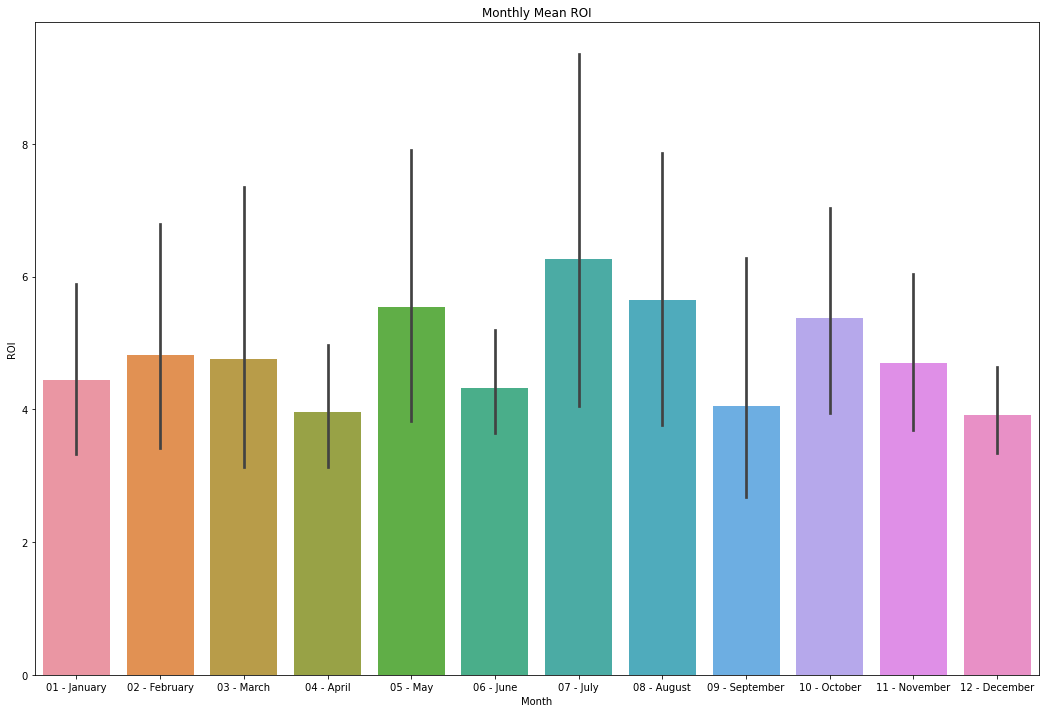

In [20]:
### Using seaborn to get a pretty graph of ROI by month. Also, automates a lot of previous work. C'est la vie.
### Default estimator is mean, which works for us.

figure(figsize=(18, 12))
plt.title('Monthly Mean ROI')
sns.barplot(data = months_and_years_df.sort_values('alphaMonths'), x = 'alphaMonths', y = 'ROI')
plt.xlabel('Month');

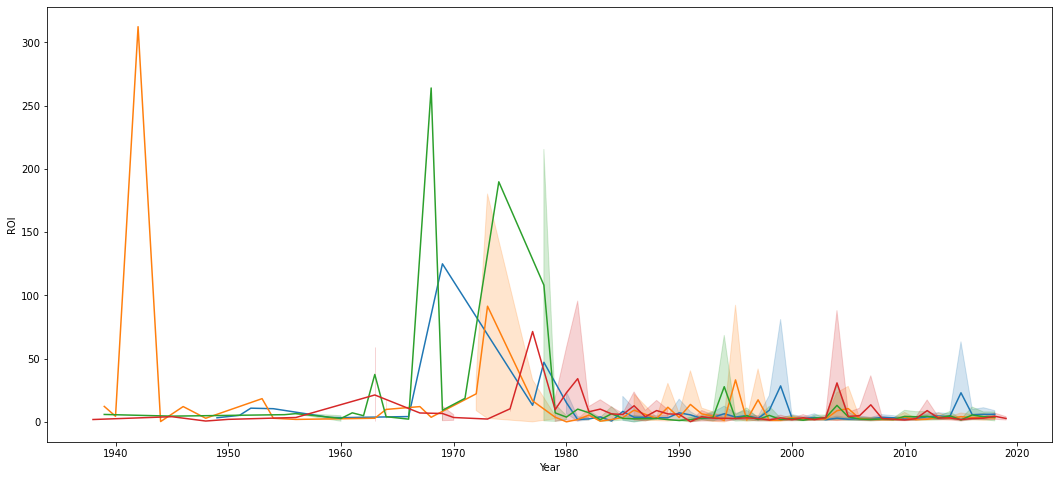

In [21]:
#Graphs a number of months by year. Note the way just a little data in ye' olden days messes up the graph


figure(figsize=(18, 8))


sns.lineplot(data = jul_mmmr_df, x = 'Year', y = 'ROI');
sns.lineplot(data = aug_mmmr_df, x = 'Year', y = 'ROI');
sns.lineplot(data = oct_mmmr_df, x = 'Year', y = 'ROI');
sns.lineplot(data = may_mmmr_df, x = 'Year', y = 'ROI');



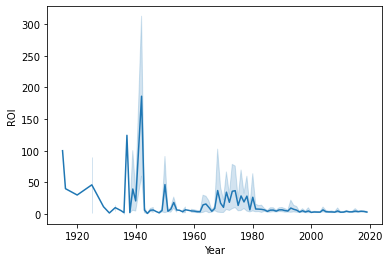

In [22]:
### Looks at industry wide ROI
### It seems like the movie bussiness has gotten less lucrative, but I suspect that 
### this is both an artifact of small data size and survivorship bias in the old data
sns.lineplot(data = months_and_years_df, x = 'Year', y = 'ROI');


In [23]:
#Let's push this to be a post 1970's display. A lot of the pre-70s data is too thin on the ground.
#Most execs' oldest movie memories probably goes back to about the 80's

post_70s_df =  months_and_years_df[months_and_years_df['Year'] >= 1980]

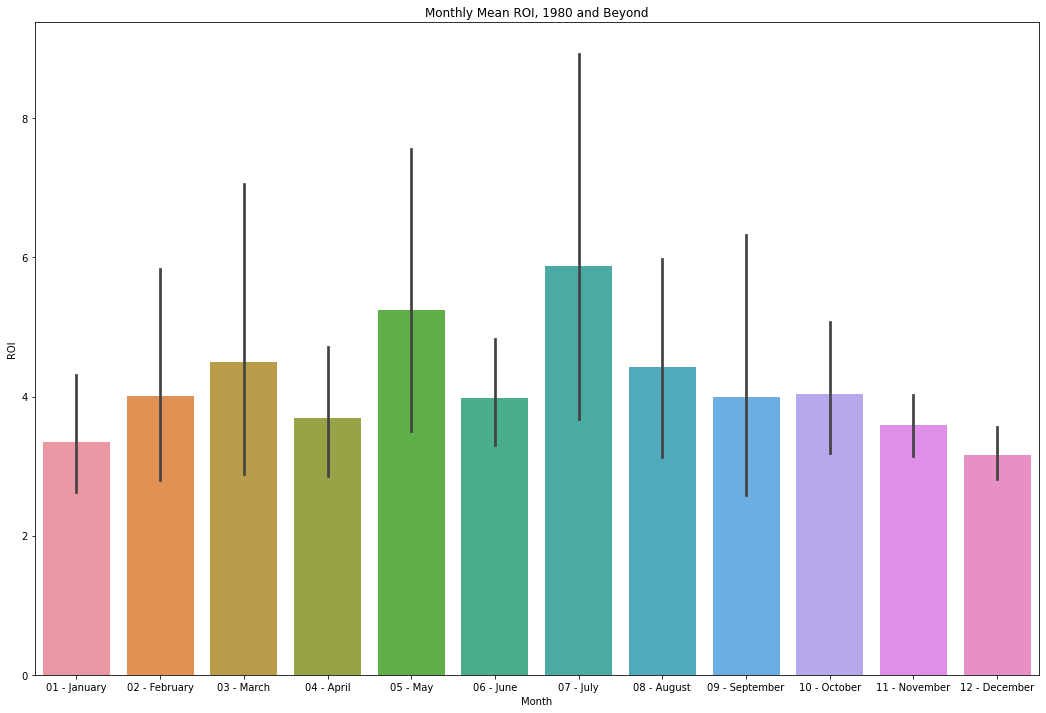

In [38]:
### a post 1980 graph by months
figure(figsize=(18, 12))
plt.title('Monthly Mean ROI, 1980 and Beyond')
sns.barplot(data = post_70s_df.sort_values('alphaMonths'), x = 'alphaMonths', y = 'ROI')
plt.xlabel('Month');

#May and July stand out.

In [25]:
#Breaking these out monthly, since that's what I'm looking for here.

post70s_jan_mmmr_df = month_iso(post_70s_df,'Jan')
post70s_feb_mmmr_df = month_iso(post_70s_df,'Feb')
post70s_mar_mmmr_df = month_iso(post_70s_df,'Mar')
post70s_apr_mmmr_df = month_iso(post_70s_df,'Apr')
post70s_may_mmmr_df = month_iso(post_70s_df,'May')
post70s_jun_mmmr_df = month_iso(post_70s_df,'Jun')
post70s_jul_mmmr_df = month_iso(post_70s_df,'Jul')
post70s_aug_mmmr_df = month_iso(post_70s_df,'Aug')
post70s_sep_mmmr_df = month_iso(post_70s_df,'Sep')
post70s_oct_mmmr_df = month_iso(post_70s_df,'Oct')
post70s_nov_mmmr_df = month_iso(post_70s_df,'Nov')
post70s_dec_mmmr_df = month_iso(post_70s_df,'Dec')





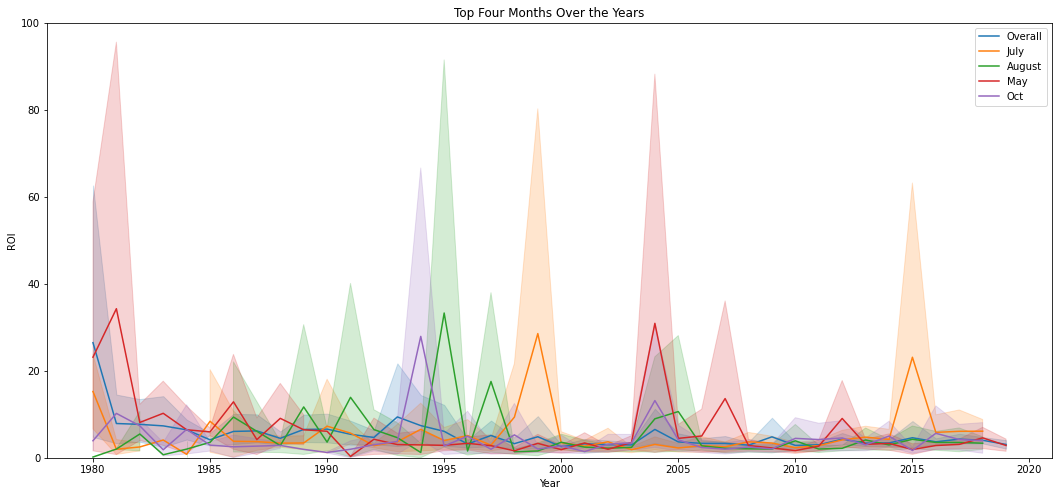

In [26]:
#Plotting
#Here I'm focusing on the top 4 months, mostly because more is illegible.
figure(figsize=(18, 8))

sns.lineplot(data = post_70s_df,x = 'Year', y = 'ROI')
sns.lineplot(data = post70s_jul_mmmr_df, x = 'Year', y = 'ROI'  )
sns.lineplot(data = post70s_aug_mmmr_df, x = 'Year', y = 'ROI'  )
sns.lineplot(data = post70s_may_mmmr_df, x = 'Year', y = 'ROI'  )
sns.lineplot(data = post70s_oct_mmmr_df, x = 'Year', y = 'ROI'  )
plt.ylim(0, 100)
plt.title('Top Four Months Over the Years')
plt.legend(labels=['Overall', 'July', 'August', 'May', 'Oct']);

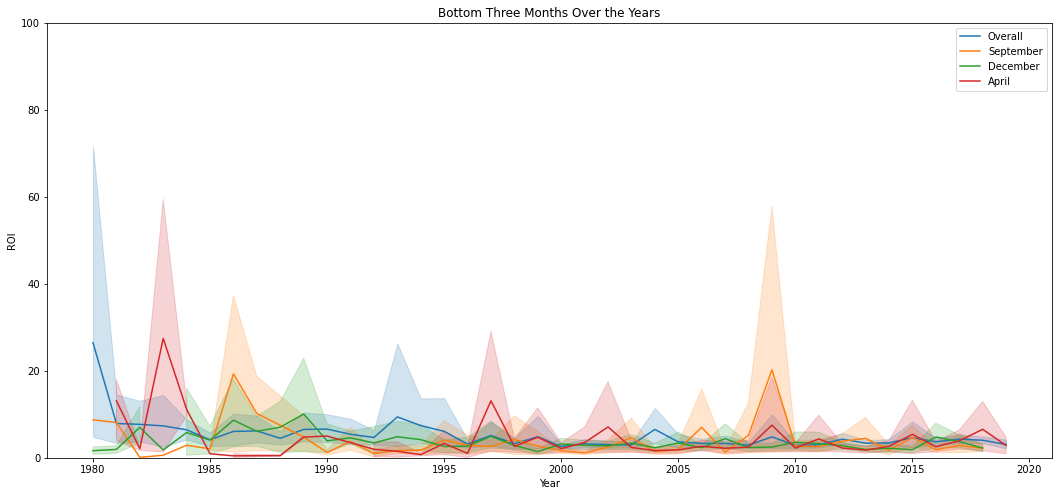

In [27]:
#Likewise, our bottom 3
#Pegged the max to 100 to keep y scale the same as the top 4 chart


figure(figsize=(18, 8))

sns.lineplot(data = post_70s_df,x = 'Year', y = 'ROI')
sns.lineplot(data = post70s_sep_mmmr_df, x = 'Year', y = 'ROI'  )
sns.lineplot(data = post70s_dec_mmmr_df, x = 'Year', y = 'ROI'  )
sns.lineplot(data = post70s_apr_mmmr_df, x = 'Year', y = 'ROI'  )
plt.ylim(0, 100)
plt.title('Bottom Three Months Over the Years')

plt.legend(labels=['Overall', 'September', 'December', 'April']);

''

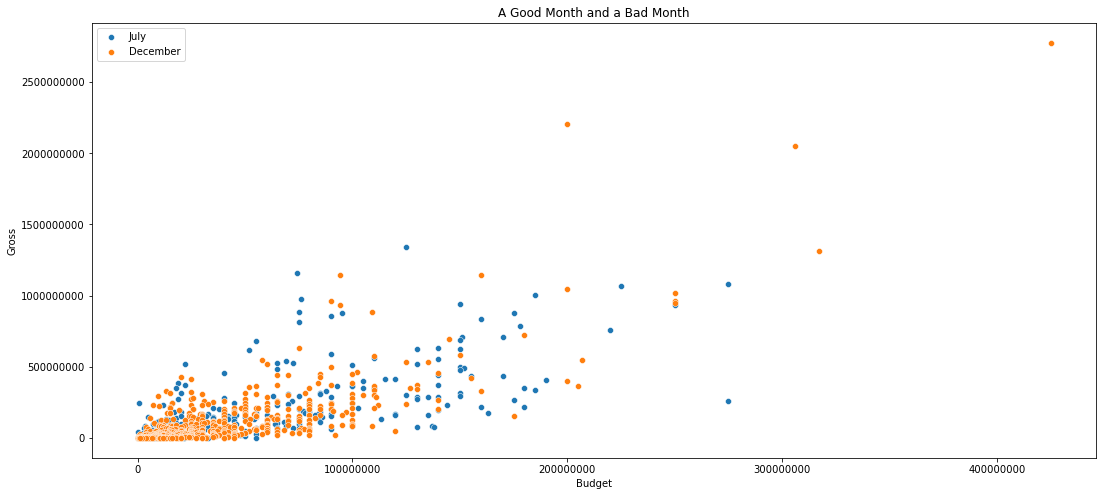

In [60]:
#Top and bottom

figure(figsize=(18, 8))

#sns.scatterplot(data = post_70s_df,x = 'Year', y = 'ROI')

sns.scatterplot(data = post70s_jul_mmmr_df, x = 'production_budget', y = 'worldwide_gross'  )
sns.scatterplot(data = post70s_dec_mmmr_df, x = 'production_budget', y = 'worldwide_gross'  )
plt.title('A Good Month and a Bad Month')
plt.ticklabel_format(style='plain')

plt.legend(labels=['July','December'])
plt.xlabel('Budget')
plt.ylabel('Gross')

;


In [29]:
### Pulling examples:
### Despite beating other months ON AVERAGE, May ROI often lags behind even the yearly average.
### Despite lagging behind other months, even September has had good years.
### Often this is led by a single stand out hit pulling up the average.

sept_by_ROI = post70s_sep_mmmr_df.sort_values('ROI',ascending = False)
ROI_2009 = years_and_dfs[2009].sort_values('ROI',ascending = False)
sep_2009 = month_iso( ROI_2009, 'Sep')

In [30]:
##Exploring
may_by_ROI = post70s_may_mmmr_df.sort_values('ROI',ascending = False)
ROI_1981 = years_and_dfs[1981].sort_values('ROI',ascending = False)
may_1981 = month_iso( ROI_1981, 'May')
may_1981


###May 1981 way outstrips its rivals... based on three data points, one of which is Graduation Day



,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN,alphaMonths
30,Graduation Day,69,"May 1, 1981",250000,23894000,23894000,5568,0.989537,95.576000,1981,May,NaN,True,05 - May
736,The Four Seasons,88,"May 22, 1981",6500000,42488161,42488161,4087,0.847016,6.536640,1981,May,NaN,True,05 - May
3998,The Legend of the Lone Ranger,18,"May 22, 1981",18000000,13400000,13400000,2817,-0.343284,0.744444,1981,May,NaN,True,05 - May


In [31]:
##Exploring
ROI_2004 = years_and_dfs[2004].sort_values('ROI',ascending = False)
May_2004 =  month_iso(ROI_2004, 'May')
May_2004
###May's peak in 2004 relies a lot on its own outlier, Super Size Me 

,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN,alphaMonths
5,Super Size Me,10,"May 7, 2004",65000,11529368,22233808,5709,0.997077,342.058585,2004,May,NaN,True,05 - May
269,Shrek 2,93,"May 19, 2004",70000000,441226247,937008132,692,0.925294,13.385830,2004,May,NaN,True,05 - May
1176,The Day After Tomorrow,70,"May 28, 2004",125000000,186740799,556319450,269,0.775309,4.450556,2004,May,NaN,True,05 - May
1732,Troy,82,"May 14, 2004",150000000,133298577,484161265,181,0.690186,3.227742,2004,May,NaN,True,05 - May
2585,Saved!,24,"May 28, 2004",5000000,8886160,10206551,4323,0.510119,2.041310,2004,May,NaN,True,05 - May
2828,Van Helsing,21,"May 7, 2004",170000000,120150546,300150546,120,0.433618,1.765591,2004,May,NaN,True,05 - May
3216,Breakin' All the Rules,89,"May 14, 2004",9000000,12232382,12512317,3788,0.280709,1.390257,2004,May,NaN,True,05 - May
3659,Raising Helen,55,"May 28, 2004",50000000,37485528,49928680,1154,-0.001428,0.998574,2004,May,NaN,True,05 - May
3781,Soul Plane,58,"May 28, 2004",16000000,13922211,14553807,2957,-0.099369,0.909613,2004,May,NaN,True,05 - May
4268,New York Minute,10,"May 7, 2004",40000000,14018364,21215882,1509,-0.885380,0.530397,2004,May,NaN,True,05 - May


In [32]:
##Exploring

In [33]:
##Exploring
money_metrics_merge_ready.sort_values('ROI',ascending = False).head(100)

,Movie,id,release_date,production_budget,domestic_gross,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN
0,Deep Throat,46,"Jun 30, 1972",25000,45000000,45000000,5745,0.999444,1800.000000,1972,Jun,NaN,True
1,Mad Max,14,"Mar 21, 1980",200000,8750000,99750000,5613,0.997995,498.750000,1980,Mar,NaN,True
2,Paranormal Activity,93,"Sep 25, 2009",450000,107918810,194183034,5492,0.997683,431.517853,2009,Sep,NaN,True
3,The Gallows,80,"Jul 10, 2015",100000,22764410,41656474,5679,0.997599,416.564740,2015,Jul,NaN,True
4,The Blair Witch Project,7,"Jul 14, 1999",600000,140539099,248300000,5406,0.997584,413.833333,1999,Jul,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Juno,86,"Dec 5, 2007",7000000,143495265,231450102,3985,0.969756,33.064300,2007,Dec,NaN,True
96,Insidious Chapter 2,53,"Sep 13, 2013",5000000,83586447,161921515,4252,0.969121,32.384303,2013,Sep,NaN,True
97,Home Alone,92,"Nov 16, 1990",15000000,285761243,476684675,2991,0.968533,31.778978,1990,Nov,NaN,True
98,Dangal,56,"Dec 21, 2016",9500000,12391761,294654618,3755,0.967759,31.016276,2016,Dec,NaN,True
